# Project

---

#Import Libraries & Declare paths

In [8]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  import warnings
  warnings.simplefilter("ignore")
except:
  print("No-drive")

# We install the Simple Transformers library to use Transformer models in a simple way
!pip install simpletransformers
import pandas as pd
import numpy as np
import csv
import os
import time
from pathlib import Path
import logging
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import nltk
import pickle
nltk.download('names')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import names
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import string
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier

import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoModel, AutoTokenizer
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModel, AutoTokenizer
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

Mounted at /content/drive


[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


device(type='cpu')

In [9]:
# For logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

path_model="drive/MyDrive/Progetti-ING/model/"
path_data="drive/MyDrive/Progetti-ING/data/"

enum_VerdictType={
            0: "Accepted",1:"Rejected",2:"Improcedibile",3:"Inammissibile",4:"Mixed",5:"NotComputed"
        }

enum_MixType={
            0:"Not_Mixed",
            1:"Mixed_Accepted_Rejected",
            2:"Mixed_Accepted_Improcedibile",
            3:"Mixed_Accepted_Inammissibile",
            4:"Mixed_Rejected_Improcedibile",
            5:"Mixed_Rejected_Inammisibile",
            6:"Mixed_Improcedibile_Inammissibile",
            7:"Mixed_Accepted_Rejected_Improcedibile",
            8:"Mixed_Accepted_Rejected_Inammissibile",
            9:"Mixed_Accepted_Improcedibile_Inammissibile",
            10:"Mixed_Rejected_Inammissibile_Improcedibile",
            11:"Mixed_Accepted_Rejected_Inammissibile_improcedibile"
        }
columns= ["Id","PQM","FactAndLaw","Tribunal","Topics","Verdict"]

---
# Data Extraction
---

In [ ]:
df_sentence = pd.read_csv(path_data+"dataset_no_mixed.csv",  sep=";;;;", encoding="utf-8")#, on_bad_lines='skip'
print("La dimensione del dataset è la seguente: ",len(df_sentence))
df_sentence.head(2)

La dimensione del dataset è la seguente:  80944


,Id,PQM,FactAndLaw,Tribunal,Topics,Verdict
0,ga-tar_cz-2021-3-1,Il Tribunale Amministrativo Regionale per la C...,"-OMISSIS-, Luogotenente dell&rsquo;Arma dei Ca...",tar_cz,"""[{""""Topic"""":""""Procedimento amministrativo"""",""...","""{""""Verdict"""":0,""""Mix"""":0}"""
1,ga-tar_fi-2021-3-1,Il Tribunale Amministrativo Regionale per la T...,La ricorrente agisce per ottenere l&rsquo;acce...,tar_fi,"""[{""""Topic"""":""""Sospensione Concessione"""",""""Con...","""{""""Verdict"""":1,""""Mix"""":0}"""


---
# Data analysis
---

In [ ]:
df=df_sentence.copy()
df_without_duplicates = df.drop_duplicates()
df_without_duplicates.reset_index(drop=True,inplace=True)
print("La dimensione del dataset è la seguente: ",len(df_without_duplicates))
df_without_duplicates.head(2)['FactAndLaw'][0]

La dimensione del dataset è la seguente:  80005


"-OMISSIS-, Luogotenente dell&rsquo;Arma dei Carabinieri, ha impugnato con richiesta di sospensione, la sanzione di stato della &ldquo;sospensione disciplinare dall&rsquo;impiego&rdquo; per mesi 8 comminata per avere il militare ricevuto avviso di garanzia per concorso in estorsione con metodo mafioso per omesso intervento in appurata vicenda estorsiva a danno di imprenditore. A sostegno del ricorso ha lamentato la violazione dell&rsquo;art. 1393, secondo e terzo capoverso, del C.O.M in quanto la fattispecie andrebbe sussunta nella residuata ipotesi di pregiudiziale penale, la violazione dei termini del procedimento disciplinare, l&rsquo;eccesso di potere per difetto di istruttoria e la violazione del principio di proporzionalit&agrave;. Ha, altres&igrave; domandato il risarcimento del danno di natura patrimoniale conseguente alla sanzione per la derivata riduzione dello stipendio, per le conseguenze sullo stato di servizio e pensionistico e di natura non patrimoniale per il danno all&

In [ ]:
df_without_duplicates=df_without_duplicates.dropna( subset=['FactAndLaw']).reset_index(drop=True)
print(df_without_duplicates.isna().sum())

Id            0
PQM           0
FactAndLaw    0
Tribunal      0
Topics        0
Verdict       0
dtype: int64


## Sentence labels creation
---

In [ ]:
import json
def convert_target(col):
  target_col=[]
  target_col_agg=[]
  target_col_num=[]
  target_col_agg_num=[]
  for el in col:

    if len(el)==27 or len(el)==28:
      # print(el[14])
      # print(el[24])
      if (int(el[14])==4):
        if(el[25]!='}'):
          target=enum_MixType[int(el[24:26])]
          tn=int(el[24:26])
        else:
          target=enum_MixType[int(el[24])]
          tn=int(el[24])
      else:
        target=enum_VerdictType[int(el[14])]
        tn=int(el[14])
      # print(target)
      target_col_agg.append(enum_VerdictType[int(el[14])])
      target_col.append(target)

      target_col_agg_num.append(int(el[14]))
      target_col_num.append(tn)
    else:
      target_col.append(None)
      target_col_agg.append(None)
      target_col_num.append(None)
      target_col_agg_num.append(None)
      print(el)
  return target_col,target_col_agg,target_col_num,target_col_agg_num

target_col,target_col_agg,target_col_num,target_col_agg_num=convert_target(df_without_duplicates["Verdict"])
df_without_duplicates["result"]=target_col
df_without_duplicates["result_agg"]=target_col_agg
df_without_duplicates["result_num"]=target_col_num
df_without_duplicates["result_agg_num"]=target_col_agg_num
df_without_duplicates

Verdict


,Id,PQM,FactAndLaw,Tribunal,Topics,Verdict,result,result_agg,result_num,result_agg_num
0,ga-tar_cz-2021-3-1,Il Tribunale Amministrativo Regionale per la C...,"-OMISSIS-, Luogotenente dell&rsquo;Arma dei Ca...",tar_cz,"""[{""""Topic"""":""""Procedimento amministrativo"""",""...","""{""""Verdict"""":0,""""Mix"""":0}""",Accepted,Accepted,0.0,0.0
1,ga-tar_fi-2021-3-1,Il Tribunale Amministrativo Regionale per la T...,La ricorrente agisce per ottenere l&rsquo;acce...,tar_fi,"""[{""""Topic"""":""""Sospensione Concessione"""",""""Con...","""{""""Verdict"""":1,""""Mix"""":0}""",Rejected,Rejected,1.0,1.0
2,ga-cgagiur-2021-3-11,Il Consiglio di Giustizia Amministrativa per l...,1 Il Comune di Acireale indiceva una gara per ...,cgagiur,"""[{""""Topic"""":""""Ambiente"""",""""Confidence"""":0.144...","""{""""Verdict"""":0,""""Mix"""":0}""",Accepted,Accepted,0.0,0.0
3,ga-tar_aq-2021-3-1,Il Tribunale Amministrativo Regionale per l'Ab...,"In data 12/4/2019, la societ&agrave; ricorrent...",tar_aq,"""[{""""Topic"""":""""Enti locali"""",""""Confidence"""":0....","""{""""Verdict"""":0,""""Mix"""":0}""",Accepted,Accepted,0.0,0.0
4,ga-tar_ge-2021-3-1,Il Tribunale Amministrativo Regionale per la L...,Con ricorso notificato il 7 maggio 2019 e depo...,tar_ge,"""[{""""Topic"""":""""Edilizia"""",""""Confidence"""":0.220...","""{""""Verdict"""":0,""""Mix"""":0}""",Accepted,Accepted,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
80000,ga-tar_ct-2014-1905-1,Il Tribunale Amministrativo Regionale per la S...,"Con il ricorso in esame, ritualmente notificat...",tar_ct,"""[{""""Topic"""":""""Sospensione Concessione"""",""""Con...","""{""""Verdict"""":3,""""Mix"""":0}""",Inammissibile,Inammissibile,3.0,3.0
80001,ga-tar_pa-2014-1904-1,Il Tribunale Amministrativo Regionale per la S...,"Con ricorso, notificato il 7 aprile 2004 e dep...",tar_pa,"""[{""""Topic"""":""""Sospensione Concessione"""",""""Con...","""{""""Verdict"""":3,""""Mix"""":0}""",Inammissibile,Inammissibile,3.0,3.0
80002,ga-tar_mi-2014-1904-1,Il Tribunale Amministrativo Regionale per la L...,Con ricorso notificato il 5 marzo 2013 e depos...,tar_mi,"""[{""""Topic"""":""""Sospensione Concessione"""",""""Con...","""{""""Verdict"""":3,""""Mix"""":0}""",Inammissibile,Inammissibile,3.0,3.0
80003,ga-tar_mi-2014-1903-1,Il Tribunale Amministrativo Regionale per la L...,"Parte ricorrente impugna gli atti impugnati, c...",tar_mi,"""[{""""Topic"""":""""Procedimento amministrativo"""",""...","""{""""Verdict"""":3,""""Mix"""":0}""",Inammissibile,Inammissibile,3.0,3.0


In [ ]:
print("-----------\nbefore\n",df_without_duplicates.isna().sum())
df_without_duplicates=df_without_duplicates.dropna().reset_index(drop=True)
print("-----------\nafter\n",df_without_duplicates.isna().sum())

-----------
before
 Id                0
PQM               0
FactAndLaw        0
Tribunal          0
Topics            0
Verdict           0
result            1
result_agg        1
result_num        1
result_agg_num    1
dtype: int64
-----------
after
 Id                0
PQM               0
FactAndLaw        0
Tribunal          0
Topics            0
Verdict           0
result            0
result_agg        0
result_num        0
result_agg_num    0
dtype: int64


In [ ]:
print(df_without_duplicates["result"].unique(),"\n",len(df_without_duplicates["result"].unique()))
print(df_without_duplicates["result_agg"].unique(),"\n",len(df_without_duplicates["result_agg"].unique()))

['Accepted' 'Rejected' 'Improcedibile' 'Inammissibile'] 
 4
['Accepted' 'Rejected' 'Improcedibile' 'Inammissibile'] 
 4


In [ ]:
# indexNames = df_without_duplicates[ df_without_duplicates['result_agg_num'] == 4.0 ].index
# # Delete these row indexes from dataFrame
# df_without_duplicates.drop(indexNames , inplace=True)
# df_without_duplicates

---
# Data_Visualization
---

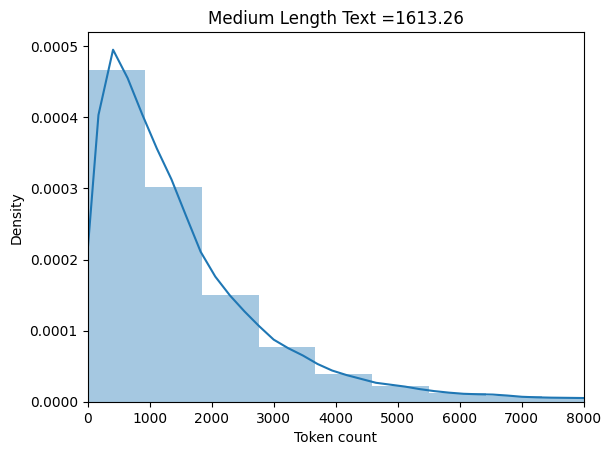

In [ ]:

def plot_token_occ(x,start,end, genere,title):
    token_lens = []
    for txt in x:
        txt_l=(str(txt)).split(' ')
        token_lens.append(len(txt_l))
    media=np.mean(token_lens)
    sns.distplot(token_lens)
    plt.xlim([start,end])
    plt.xlabel('Token count')
    plt.title(title+genere+" ="+ str(round(media,2)))
    plt.show()

df=df_without_duplicates
plot_token_occ(df['FactAndLaw'].tolist(),0,8000,'','Medium Length Text')

In [ ]:
from random import randint
def plotta_label_pie_from_dict(occorrenze,size=(20,20),valori_plottati=2,title_chart='tipologia',fz=40):
    #ordina dizionario
    lb=list(occorrenze.keys())
    diz={}
    occ=list(occorrenze.values())
    for i in range (len(occorrenze)):
        diz[lb[i]]=occ[i]
    sorted_dict = {}
    sorted_dict = sorted(diz.items(), key = lambda kv: kv[1])

    stampa={}
    num_stampe=valori_plottati
    for i in range (len(occorrenze)-num_stampe,len(occorrenze)):
        stampa[sorted_dict[i][0]]=int(sorted_dict[i][1])


    if(len(occorrenze)-num_stampe)>0:
        stampa['altri']=0
        for i in range (len(occorrenze)-num_stampe):
            stampa['altri']+=int(sorted_dict[i][1])
    #stampa=occorrenze
    t=len(stampa)
    cs = []
    n = t
    for i in range(n):
        cs.append('#%06X' % randint(0, 0xFFFFFF))
    labels = list(stampa.keys())
    sizes = list(stampa.values())
    explode = np.zeros(t)
    explode[t-2]=0.1
    fig1, ax1 = plt.subplots(figsize=size)
    ax1.pie(sizes, explode=explode,  autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 8},colors=cs)
    ax1.axis('equal')
    ax1.legend(labels, prop={'size': 10})
    plt.title(title_chart,fontsize=fz)
    plt.show()

occorrenze_sentence={'Accepted':(df['result']=='Accepted').sum(),
                     'Rejected':(df['result']=='Rejected').sum(),
                     'Improcedibile':(df['result']=='Improcedibile').sum(),
                     'Inammissibile':(df['result']=='Inammissibile').sum(),
                     'NotComputed':(df['result']=='NotComputed').sum(),
                     'Not_Mixed':(df['result']=='Not_Mixed').sum(),
                     'Mixed_Accepted_Rejected':(df['result']=='Mixed_Accepted_Rejected').sum(),
                     'Mixed_Accepted_Improcedibile':(df['result']=='Mixed_Accepted_Improcedibile').sum(),
                     'Mixed_Accepted_Inammissibile':(df['result']=='Mixed_Accepted_Inammissibile').sum(),
                     'Mixed_Rejected_Improcedibile':(df['result']=='Mixed_Rejected_Improcedibile').sum(),
                     'Mixed_Rejected_Inammisibile':(df['result']=='Mixed_Rejected_Inammisibile').sum(),
                     'Mixed_Improcedibile_Inammissibile':(df['result']=='Mixed_Improcedibile_Inammissibile').sum(),
                     'Mixed_Accepted_Rejected_Improcedibile':(df['result']=='Mixed_Accepted_Rejected_Improcedibile').sum(),
                     'Mixed_Accepted_Rejected_Inammissibile':(df['result']=='Mixed_Accepted_Rejected_Inammissibile').sum(),
                     'Mixed_Accepted_Improcedibile_Inammissibile':(df['result']=='Mixed_Accepted_Improcedibile_Inammissibile').sum(),
                     'Mixed_Rejected_Inammissibile_Improcedibile':(df['result']=='Mixed_Rejected_Inammissibile_Improcedibile').sum(),
                     'Mixed_Accepted_Rejected_Inammissibile_improcedibile':(df['result']=='Mixed_Accepted_Rejected_Inammissibile_improcedibile').sum()}

print(occorrenze_sentence)
# plotta_label_pie_from_dict(occorrenze_sentence,size=(12,12),valori_plottati=9,title_chart='Sentence Distribution')

{'Accepted': 20001, 'Rejected': 20001, 'Improcedibile': 20001, 'Inammissibile': 20001, 'NotComputed': 0, 'Not_Mixed': 0, 'Mixed_Accepted_Rejected': 0, 'Mixed_Accepted_Improcedibile': 0, 'Mixed_Accepted_Inammissibile': 0, 'Mixed_Rejected_Improcedibile': 0, 'Mixed_Rejected_Inammisibile': 0, 'Mixed_Improcedibile_Inammissibile': 0, 'Mixed_Accepted_Rejected_Improcedibile': 0, 'Mixed_Accepted_Rejected_Inammissibile': 0, 'Mixed_Accepted_Improcedibile_Inammissibile': 0, 'Mixed_Rejected_Inammissibile_Improcedibile': 0, 'Mixed_Accepted_Rejected_Inammissibile_improcedibile': 0}


{'Accepted': 20001, 'Rejected': 20001, 'Improcedibile': 20001, 'Inammissibile': 20001, 'Mixed': 0, 'NotComputed': 0}


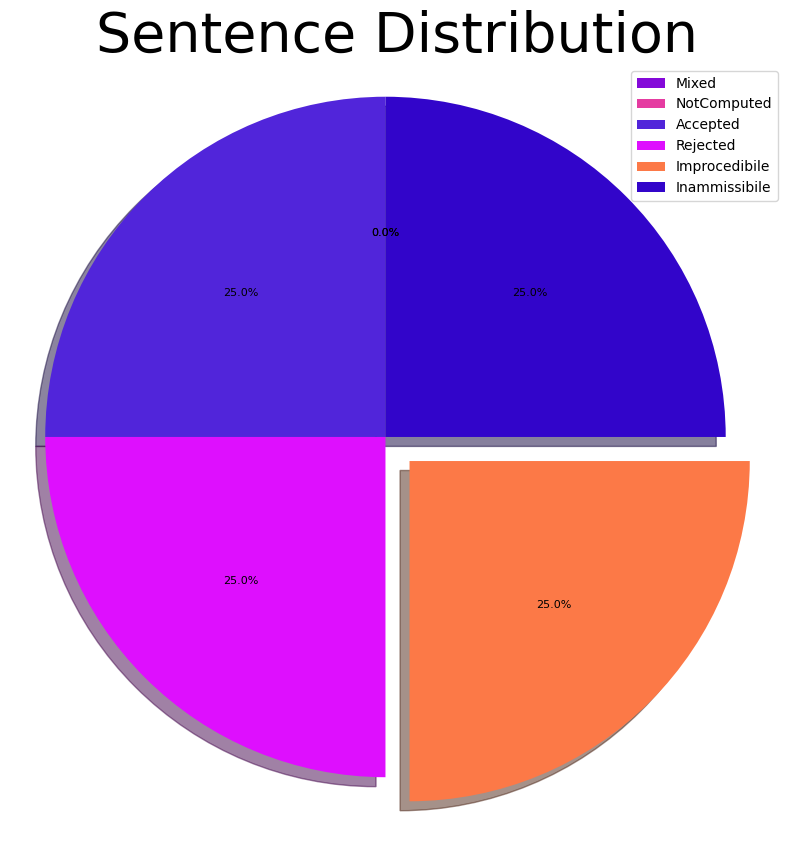

In [ ]:
occorrenze_sentence={'Accepted':(df['result_agg']=='Accepted').sum(),
                     'Rejected':(df['result_agg']=='Rejected').sum(),
                     'Improcedibile':(df['result_agg']=='Improcedibile').sum(),
                     'Inammissibile':(df['result_agg']=='Inammissibile').sum(),
                     'Mixed':(df['result_agg']=='Mixed').sum(),
                     'NotComputed':(df['result_agg']=='NotComputed').sum()}

print(occorrenze_sentence)
plotta_label_pie_from_dict(occorrenze_sentence,size=(10,10),valori_plottati=6,title_chart='Sentence Distribution')

---
# Data Preparation
---

In [ ]:
df["Text"]=df["FactAndLaw"]+"\n\n"+df["PQM"]+"\n\n"+df["Tribunal"]
df=df.drop(["Id","Topics","Verdict"],axis=1)
df=df.drop(["PQM","Tribunal"],axis=1)
df

,FactAndLaw,result,result_agg,result_num,result_agg_num,Text
0,"-OMISSIS-, Luogotenente dell&rsquo;Arma dei Ca...",Accepted,Accepted,0.0,0.0,"-OMISSIS-, Luogotenente dell&rsquo;Arma dei Ca..."
1,La ricorrente agisce per ottenere l&rsquo;acce...,Rejected,Rejected,1.0,1.0,La ricorrente agisce per ottenere l&rsquo;acce...
2,1 Il Comune di Acireale indiceva una gara per ...,Accepted,Accepted,0.0,0.0,1 Il Comune di Acireale indiceva una gara per ...
3,"In data 12/4/2019, la societ&agrave; ricorrent...",Accepted,Accepted,0.0,0.0,"In data 12/4/2019, la societ&agrave; ricorrent..."
4,Con ricorso notificato il 7 maggio 2019 e depo...,Accepted,Accepted,0.0,0.0,Con ricorso notificato il 7 maggio 2019 e depo...
...,...,...,...,...,...,...
79999,"Con il ricorso in esame, ritualmente notificat...",Inammissibile,Inammissibile,3.0,3.0,"Con il ricorso in esame, ritualmente notificat..."
80000,"Con ricorso, notificato il 7 aprile 2004 e dep...",Inammissibile,Inammissibile,3.0,3.0,"Con ricorso, notificato il 7 aprile 2004 e dep..."
80001,Con ricorso notificato il 5 marzo 2013 e depos...,Inammissibile,Inammissibile,3.0,3.0,Con ricorso notificato il 5 marzo 2013 e depos...
80002,"Parte ricorrente impugna gli atti impugnati, c...",Inammissibile,Inammissibile,3.0,3.0,"Parte ricorrente impugna gli atti impugnati, c..."


In [ ]:
clear_ds=df
y_label_code_agg=df["result_agg_num"]
y_label_code=df["result_agg"]

In [ ]:
def preprocessing(ds,print_val=2000,first=0,end=len(df)):
    New_Testo = []
    occ=0
    occ_print=print_val
    start_time = time.time()
    print('Analizzare i testi dalla riga:',first,', alla riga:',end)
    for ind in range (first,end):
        testo = str(ds[ind])
        #LOWER_CASE
        testo= testo.lower()
        #elimina citazione no perchè non ce ne sono

        # tokenization
        word_tokens = nltk.word_tokenize(testo);

        # Rimuovi punteggiatura
        word_tokens = list(filter(lambda token: token not in string.punctuation, word_tokens))

        # stopwords list
        stop_words = set(stopwords.words('italian'))

        # stoppping
        filtered_sentence = [w for w in word_tokens if not w in stop_words]

        document = ' '.join(filtered_sentence)
        # sostituisci risultato:
        New_Testo.append(document)
        end_time = time.time()
        t = time.strftime("%Hh:%Mm:%Ss",time.gmtime(int(end_time)-int(start_time)))
        if (occ%occ_print==0 and occ!=0) or (occ==(len(ds)-1)):
            print('analizzati',occ,'record',",tempo impiegato per trasformare",occ_print,"file: "+t,'size del vettore:',len(New_Testo)-1)
            start_time = time.time()
        occ+=1
    return New_Testo

def index_download(indice_path):
    ind=0
    if not Path(indice_path).exists():
        f= open(indice_path, "w")
        f.write(str(0))
        f.close()
    f=open(indice_path,"r")
    ind=int(f.read())
    f.close()
    return int(ind)

def carica_text(indice,path_d):
    if not Path(path_d).exists():
        print('Creato file di checkpoint per il nostro array dei testi processati')
        with open(path_d, 'w') as temp:
            primo=preprocessing(testi,10,indice,indice+1)
            pp=pd.DataFrame(primo, columns = ['text'])
            pp.to_csv(temp, index=False)
            indice+=1
    with open (path_d, 'r') as temp:
        processed_text = pd.read_csv(temp)
    return processed_text,indice

def salva_text(indice,testi, indice_path, path_d):
    with open(indice_path, 'w') as temp:
        temp.truncate(0)
        temp.write(str(indice))
        temp.close()

    with open(path_d, 'w') as temp:
        testi.to_csv(temp, index=False)
    return testi

def preprocessing_col(testi, indice_path,path_d):
    print('I record in totale sono:',len(testi))
    indice=index_download(indice_path)
    print("L'ultimo checkpoit è stato al record:",indice)

    text_loaded,indice=carica_text(indice,path_d)

    stampa_ogni=(len(clear_ds))//5
    end_ds=indice+(stampa_ogni*5)
    processed_text_final=text_loaded
    if indice==1:
        end_ds-=1
    if end_ds>len(testi):
        end_ds=len(testi)
    if indice!=len(testi):
        new_text_processed=pd.DataFrame( preprocessing(testi,stampa_ogni,indice,end_ds),columns = ['text'])
        processed_text=pd.DataFrame.append(text_loaded,new_text_processed)
        processed_text_final=salva_text(end_ds,processed_text,indice_path,path_d)

    return processed_text_final


testi=clear_ds['Text'].copy().tolist()
processed_text_final=preprocessing_col(testi,path_data+"index_scan_text.txt",path_data+'outputfile_text_processed.csv')

testi_sentence=clear_ds['FactAndLaw'].copy().tolist()
processed_sentence_final=preprocessing_col(testi_sentence,path_data+"index_scan_sentence.txt",path_data+'outputfile_sentence_processed.csv')

I record in totale sono: 80004
L'ultimo checkpoit è stato al record: 80004
I record in totale sono: 80004
L'ultimo checkpoit è stato al record: 80004


In [ ]:
print(processed_text_final.info())
print("--"*30)
print(processed_sentence_final.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80004 entries, 0 to 80003
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    80004 non-null  object
dtypes: object(1)
memory usage: 625.2+ KB
None
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80004 entries, 0 to 80003
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    80004 non-null  object
dtypes: object(1)
memory usage: 625.2+ KB
None


In [ ]:
len(processed_text_final)
len(y_label_code_agg)

80004

In [ ]:
labels_agg=True
while (len(processed_text_final)==len(y_label_code_agg) and len(processed_text_final)==len(y_label_code) and len(processed_sentence_final)==len(y_label_code_agg) and len(processed_sentence_final)==len(y_label_code))==False:
  testi=clear_ds['Text'].copy().tolist()
  processed_text_final=preprocessing_col(testi,path_data+"index_scan_text.txt",path_data+'outputfile_text_processed.csv')

  testi_sentence=clear_ds['FactAndLaw'].copy().tolist()
  processed_sentence_final=preprocessing_col(testi_sentence,path_data+"index_scan_sentence.txt",path_data+'outputfile_sentence_processed.csv')
  print((len(processed_text_final)==len(y_label_code_agg) and len(processed_text_final)==len(y_label_code) and len(processed_sentence_final)==len(y_label_code_agg) and len(processed_sentence_final)==len(y_label_code)))
(len(processed_text_final)==len(y_label_code_agg) and len(processed_text_final)==len(y_label_code) and len(processed_sentence_final)==len(y_label_code_agg) and len(processed_sentence_final)==len(y_label_code))

True

In [ ]:
if labels_agg:
  arr_label = np.array(y_label_code_agg)
else:
  arr_label = np.array(y_label_code)
arr_label

array([0., 1., 0., ..., 3., 3., 3.])

---
## Preparation final Dataset
---

In [ ]:
Data_Set=pd.DataFrame({'text':list(processed_text_final['text']),'FactAndLaw':list(processed_sentence_final['text']),'target':arr_label})
Data_Set

,text,FactAndLaw,target
0,-omissis- luogotenente rsquo arma carabinieri ...,-omissis- luogotenente rsquo arma carabinieri ...,0.0
1,ricorrente agisce ottenere rsquo accesso docum...,ricorrente agisce ottenere rsquo accesso docum...,1.0
2,1 comune acireale indiceva gara rsquo affidame...,1 comune acireale indiceva gara rsquo affidame...,0.0
3,data 12/4/2019 societ agrave ricorrente presen...,data 12/4/2019 societ agrave ricorrente presen...,0.0
4,ricorso notificato 7 maggio 2019 depositato 20...,ricorso notificato 7 maggio 2019 depositato 20...,0.0
...,...,...,...
79999,ricorso esame ritualmente notificato depositat...,ricorso esame ritualmente notificato depositat...,3.0
80000,ricorso notificato 7 aprile 2004 depositato gi...,ricorso notificato 7 aprile 2004 depositato gi...,3.0
80001,ricorso notificato 5 marzo 2013 depositato 14 ...,ricorso notificato 5 marzo 2013 depositato 14 ...,3.0
80002,parte ricorrente impugna atti impugnati concer...,parte ricorrente impugna atti impugnati concer...,3.0


In [ ]:
def plot_token_occ(x,start,end, genere,title):
    token_lens = []
    for txt in x:
        txt_l=(str(txt)).split(' ')
        token_lens.append(len(txt_l))
    media=np.mean(token_lens)
    sns.histplot(token_lens)
    plt.xlim([start,end])
    plt.xlabel('Text count')
    plt.title(title+genere+" ="+ str(round(media,2)))
    plt.show()

---
## Tif idf vectorizer
---

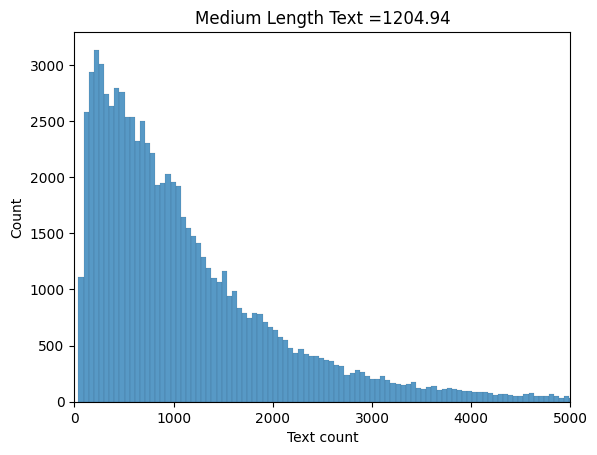

In [ ]:
plot_token_occ(Data_Set['text'].tolist(),0,5000,'','Medium Length Text')

In [ ]:
# prima splitta in train test
X = Data_Set[['text','FactAndLaw']]
y = list(Data_Set['target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42,stratify=y)
X_train=X_train['FactAndLaw']
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.33, random_state=42,stratify=y_test)
X_validation=X_validation['FactAndLaw']
X_test=X_test['FactAndLaw']
print('Size iniziale dei record:',len(list(Data_Set['text'])),'\nSize train ds:',len(X_train),', Size train label:', len(y_train),'\nSize validation ds:',len(X_validation),', Size validation label:',len(y_validation),'\nSize test ds:',len(X_test),'Size test label:', len(y_test))

Size iniziale dei record: 80004 
Size train ds: 56002 , Size train label: 56002 
Size validation ds: 16081 , Size validation label: 16081 
Size test ds: 7921 Size test label: 7921


In [ ]:
from datetime import datetime
def time_calculate(bool_t=True,start_time=0):
    if bool_t==True:
        print('START: ',datetime.today().strftime('%Y-%m-%d %H:%M'))
        return time.time()
    else:
        end_time=time.time()
        print('END: ',datetime.today().strftime('%Y-%m-%d %H:%M'))
        giorno_in_sec=86400
        giorni=(int(end_time)-int(start_time))//giorno_in_sec
        t = time.strftime("%Hh:%Mm:%Ss",time.gmtime(int(end_time)-int(start_time)))
        print("tempo impiegato "+str(giorni)+'d:'+t)
        return t

In [ ]:
print("Tf-idf")
tfizer = TfidfVectorizer(analyzer="word",
                          lowercase=True,
                          max_features=5000,
                          tokenizer=None,
                          preprocessor=None,
                          dtype=np.float32,
                          max_df=0.8,
                          min_df=0.1
                          )

start_time=time_calculate()
X_tfidf =  tfizer.fit_transform(X_train)

X_tfidf_validation = tfizer.transform(X_validation)

X_tfidf_test = tfizer.transform(X_test)
end_time=time_calculate(bool_t=False,start_time=start_time)

print('Size train vettore_ds:',X_tfidf.shape,
      '\nSize validation vettore_ds:',X_tfidf_validation.shape,
      '\nSize test vettore_ds:',X_tfidf_test.shape)

Tf-idf
START:  2023-07-27 11:40
END:  2023-07-27 11:42
tempo impiegato 0d:00h:01m:57s
Size train vettore_ds: (56002, 1080) 
Size validation vettore_ds: (16081, 1080) 
Size test vettore_ds: (7921, 1080)


In [ ]:
def controlla_features_prodotte(controlla):
    val=1
    if controlla:
        i=0
        righe_assenti_di_features=0
        for row in X_tfidf:
            row_uniq=np.unique(row.toarray()[0])
            if (len(row_uniq))<=val:
                righe_assenti_di_features+=1
                print('Indice',i,'attributi diversi da 0:',row_uniq[0])
            i+=1
        print('righe assenti di features:',righe_assenti_di_features)

def plot_classification_report(classification_report, title='', cmap='RdBu',num_class=4,size=(6,7)):
    title_='Classification report '+title
    plt.title(title_, fontsize=20)
    plt.rcParams["figure.figsize"] = size
    lines = classification_report.split('\n')
    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) )]:
        t = line.strip().split()
        if len(t) < 2: continue
        if t[1]=='avg':
            classes.append(t[0]+t[1])
            start=2
        else:
            classes.append(t[0])
            start=1
        if t[0]== 'accuracy':
            v=[float(),float(),float(t[1])]
        else:
            v = [float(x) for x in t[start: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    class_names[len(class_names)-1]=class_names[len(class_names)-1]+' avg'
    class_names[len(class_names)-2]=class_names[len(class_names)-2]+' avg'
    class_names[len(class_names)-3]=class_names[len(class_names)-3]+' avg'
    class_names[len(class_names)-4]=class_names[len(class_names)-4]+' avg'
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    plotMat.insert(num_class, plotMat[3])
    yticklabels.insert(num_class, '')
    data=pd.DataFrame(np.array(plotMat))
    data[0][num_class]=None
    data[1][num_class]=None
    data[2][num_class]=None
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    sns.heatmap(data, annot=True,xticklabels=xticklabels,yticklabels=yticklabels, annot_kws={"size": 20})
    plt.show()

start_time=time_calculate()
controlla_features_prodotte(True)
end_time=time_calculate(bool_t=False,start_time=start_time)

START:  2023-07-27 11:42
righe assenti di features: 0
END:  2023-07-27 11:42
tempo impiegato 0d:00h:00m:07s


---
# Data Model
---

In [ ]:
def train_classifier(f,model,class_names_list):
    start_time=time_calculate()

    if os.path.isfile(f):
        clf = pickle.load(open(f, 'rb'))
        multi_classifier = clf
        print("MODELLO GIA' ADDESTRATO")
    else:
        print('TRAINING MODEL')
        clf = model
        multi_classifier = OneVsRestClassifier(clf)
        multi_classifier.fit(X_tfidf, y_train);
        print("MODELLO ADDESTRATO")
        pickle.dump(multi_classifier, open(f, 'wb'))

    end_time=time_calculate(bool_t=False,start_time=start_time)

    y_pred = multi_classifier.predict(X_tfidf_validation);  # etichette predette

    if labels_agg!=True:
        cm=classification_report(y_validation, y_pred,target_names=class_names_list)
        print(f"Test Set Accuracy : {metrics.accuracy_score(y_validation, y_pred) * 100} %\n\n")
        print(f"Classification Report : \n\n{cm}")

    else:
        cm=classification_report(y_validation, y_pred,target_names=class_names_list)
        print(f"Test Set Accuracy : {metrics.accuracy_score(y_validation, y_pred) * 100} %\n\n")
        print(f"Classification Report : \n\n{cm}")

    plot_classification_report(cm, title='', cmap='RdBu',num_class=4,size=(6,7))
    return multi_classifier,y_pred

def prediction(multi_classifier,X_tfidf_validation,y_test):
    y_pred=multi_classifier.predict(X_tfidf_validation)
    if labels_agg!=True:
        cm=classification_report(y_test, y_pred,target_names=class_names_list)
        print(f"Test Set Accuracy : {metrics.accuracy_score(y_test, y_pred) * 100} %\n\n")
        print(f"Classification Report : \n\n{cm}")

    else:
        cm=classification_report(y_test, y_pred,target_names=class_names_list)
        print(f"Test Set Accuracy : {metrics.accuracy_score(y_test, y_pred) * 100} %\n\n")
        print(f"Classification Report : \n\n{cm}")

    plot_classification_report(cm, title='', cmap='RdBu',num_class=4,size=(6,7))

    return y_pred

In [ ]:
class_names_list=list(enum_VerdictType.values())
if labels_agg!=True:
  class_names_list_mixed=list(enum_MixType.values())
  class_names_list=class_names_list+class_names_list_mixed
  class_names_list.remove("Mixed")
  print(class_names_list)

if ((df['result_agg']=='NotComputed').sum()==0):
  class_names_list.remove("NotComputed")
if ((df['result']=='Not_Mixed').sum()==0) and labels_agg==False:
  class_names_list.remove("Not_Mixed")
class_names_list.remove("Mixed")
print(len(class_names_list))
class_names_list

4


['Accepted', 'Rejected', 'Improcedibile', 'Inammissibile']

---
## Adaboost
---

START:  2023-07-26 15:37
MODELLO GIA' ADDESTRATO
END:  2023-07-26 15:37
tempo impiegato 0d:00h:00m:01s
Test Set Accuracy : 86.76077358373236 %


Classification Report : 

               precision    recall  f1-score   support

     Accepted       0.85      0.85      0.85      4021
     Rejected       0.82      0.81      0.81      4020
Improcedibile       0.91      0.90      0.91      4020
Inammissibile       0.88      0.91      0.90      4020

     accuracy                           0.87     16081
    macro avg       0.87      0.87      0.87     16081
 weighted avg       0.87      0.87      0.87     16081



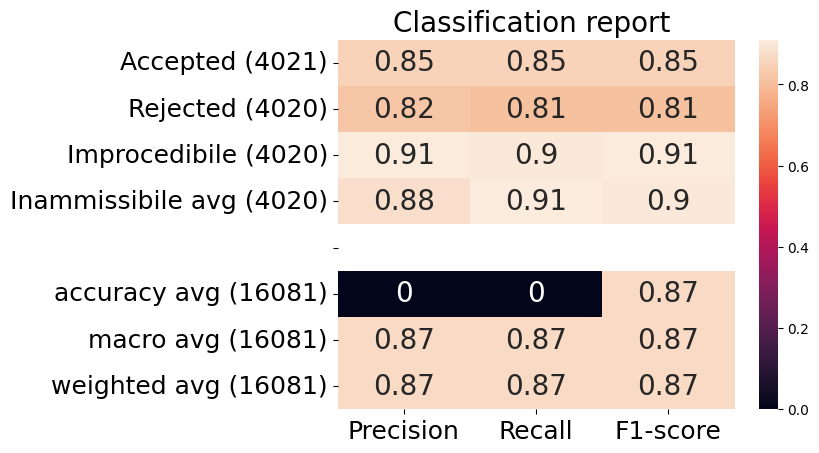

In [ ]:
path_adaboost=path_model+"ADABOOST/"
n_estimators=100
model=AdaBoostClassifier( n_estimators=n_estimators,algorithm="SAMME")
if labels_agg!=True:
    f = path_adaboost+"ADABOOST_clf_Text_"+ str(n_estimators)
else:
    f = path_adaboost+"ADABOOST_clf_Text_Agg_"+ str(n_estimators)

multi_classifier_adaboost,y_pred_adaboost=train_classifier(f,model,class_names_list)

### Prediction
---

START:  2023-07-26 15:37
Test Set Accuracy : 86.71884863022345 %


Classification Report : 

               precision    recall  f1-score   support

     Accepted       0.84      0.85      0.85      1980
     Rejected       0.82      0.81      0.81      1980
Improcedibile       0.92      0.90      0.91      1981
Inammissibile       0.89      0.91      0.90      1980

     accuracy                           0.87      7921
    macro avg       0.87      0.87      0.87      7921
 weighted avg       0.87      0.87      0.87      7921



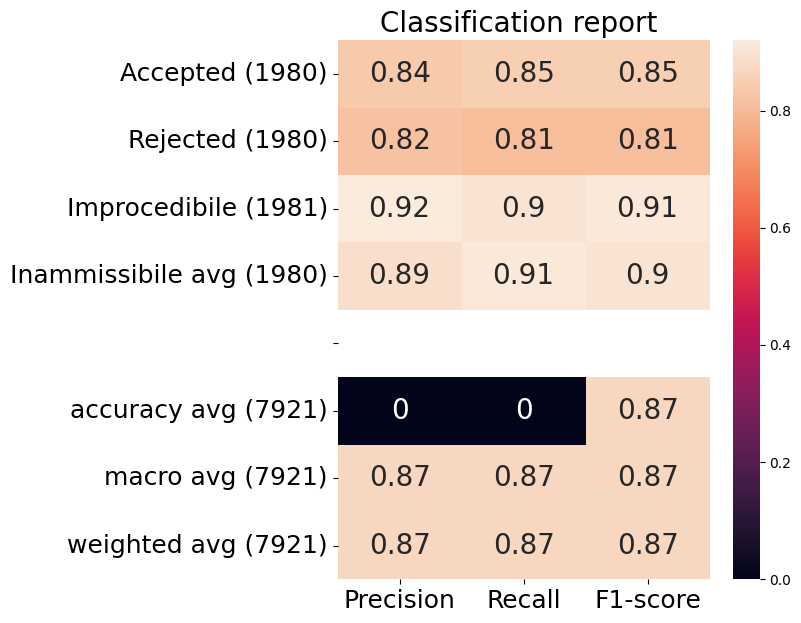

END:  2023-07-26 15:38
tempo impiegato 0d:00h:00m:03s


In [ ]:
start_time=time_calculate()
prediction(multi_classifier_adaboost,X_tfidf_test,y_test)
end_time=time_calculate(bool_t=False,start_time=start_time)

---
## SVM
---

START:  2023-07-26 15:38
MODELLO GIA' ADDESTRATO
END:  2023-07-26 15:38
tempo impiegato 0d:00h:00m:02s
Test Set Accuracy : 75.63584354206829 %


Classification Report : 

               precision    recall  f1-score   support

     Accepted       0.70      0.71      0.70      4021
     Rejected       0.72      0.66      0.69      4020
Improcedibile       0.88      0.84      0.86      4020
Inammissibile       0.73      0.82      0.77      4020

     accuracy                           0.76     16081
    macro avg       0.76      0.76      0.76     16081
 weighted avg       0.76      0.76      0.76     16081



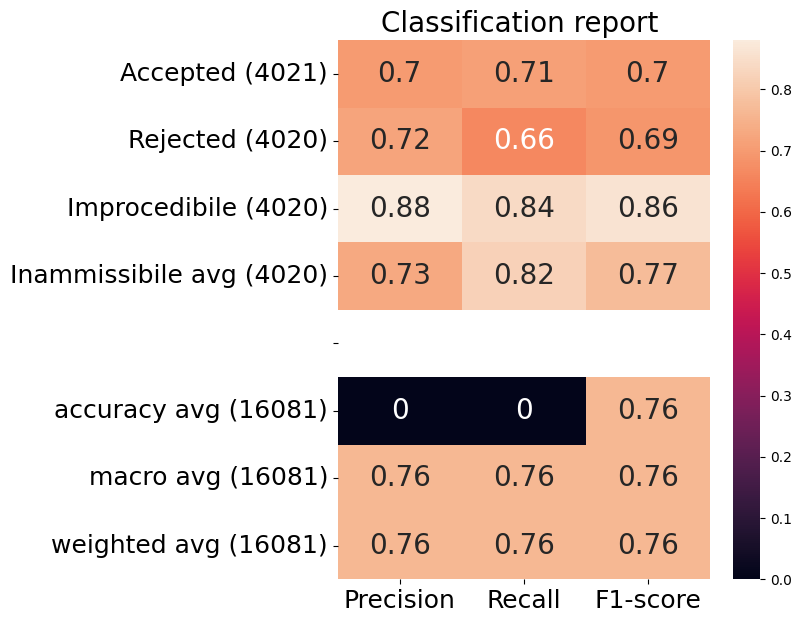

In [ ]:
# SVM con kernel sigmoid
path_svm=path_model+"SVM/"
model=SVC(kernel='sigmoid', C=1,verbose=2)
if labels_agg!=True:
    f = path_svm+"SVM_moc_clf_Text"+"sigmoid"
else:
    f = path_svm+"SVM_moc_clf_Text_agg"+"sigmoid"
multi_classifier_svm,y_pred_svm=train_classifier(f,model,class_names_list)

### Prediction
---

START:  2023-07-26 16:12
Test Set Accuracy : 75.93738164373185 %


Classification Report : 

               precision    recall  f1-score   support

     Accepted       0.70      0.70      0.70      1980
     Rejected       0.72      0.68      0.70      1980
Improcedibile       0.87      0.84      0.86      1981
Inammissibile       0.75      0.82      0.78      1980

     accuracy                           0.76      7921
    macro avg       0.76      0.76      0.76      7921
 weighted avg       0.76      0.76      0.76      7921



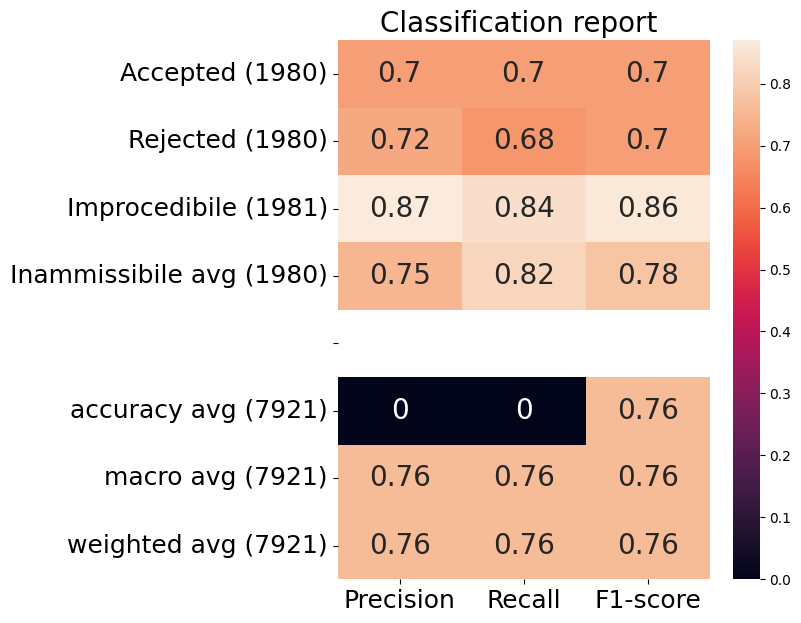

END:  2023-07-26 16:30
tempo impiegato 0d:00h:17m:22s


In [ ]:
start_time=time_calculate()
prediction(multi_classifier_svm,X_tfidf_test,y_test)
end_time=time_calculate(bool_t=False,start_time=start_time)

---
## Albero Decisionale
---

START:  2023-07-26 16:30
MODELLO GIA' ADDESTRATO
END:  2023-07-26 16:30
tempo impiegato 0d:00h:00m:00s
Test Set Accuracy : 80.11939555997762 %


Classification Report : 

               precision    recall  f1-score   support

     Accepted       0.90      0.72      0.80      4021
     Rejected       0.81      0.70      0.75      4020
Improcedibile       0.90      0.85      0.87      4020
Inammissibile       0.67      0.94      0.78      4020

     accuracy                           0.80     16081
    macro avg       0.82      0.80      0.80     16081
 weighted avg       0.82      0.80      0.80     16081



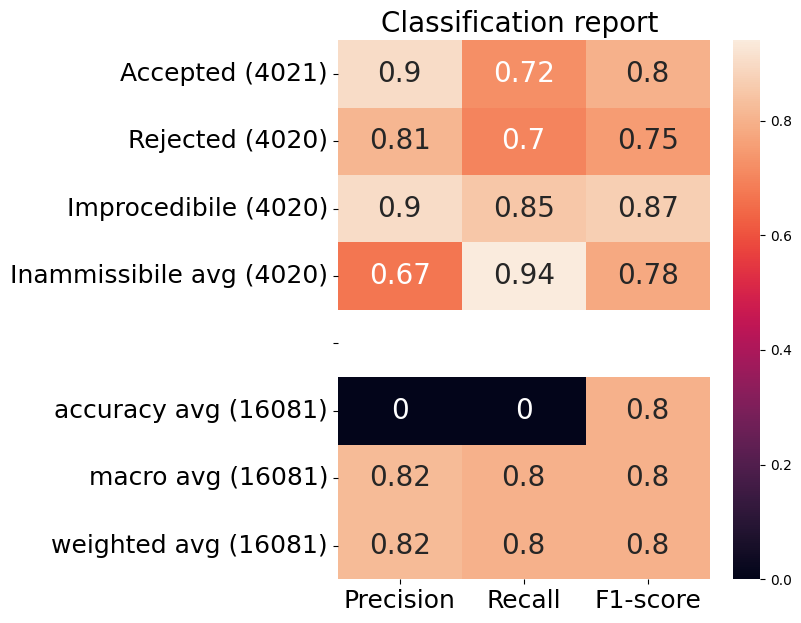

In [ ]:
path_decision_tree=path_model+"DECISIONTREE/"
model=DecisionTreeClassifier()
if labels_agg!=True:
    f = path_decision_tree+"DECISIONTREE_clf_Text"
else:
    f = path_decision_tree+"DECISIONTREE_clf_Text_agg"
multi_classifier_decisiontree,y_pred_decisiontree=train_classifier(f,model,class_names_list)

### Prediction
---

START:  2023-07-26 16:30
Test Set Accuracy : 79.76265623027395 %


Classification Report : 

               precision    recall  f1-score   support

     Accepted       0.91      0.72      0.80      1980
     Rejected       0.81      0.70      0.75      1980
Improcedibile       0.91      0.84      0.87      1981
Inammissibile       0.66      0.94      0.77      1980

     accuracy                           0.80      7921
    macro avg       0.82      0.80      0.80      7921
 weighted avg       0.82      0.80      0.80      7921



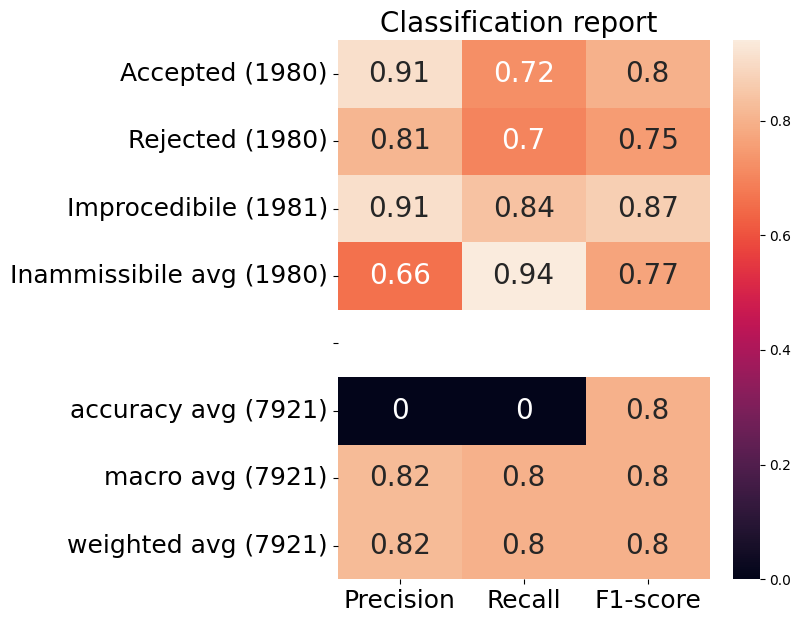

END:  2023-07-26 16:30
tempo impiegato 0d:00h:00m:00s


In [ ]:
start_time=time_calculate()
prediction(multi_classifier_decisiontree,X_tfidf_test,y_test)
end_time=time_calculate(bool_t=False,start_time=start_time)

## RandomForestClassifier

START:  2023-07-27 11:42
MODELLO GIA' ADDESTRATO
END:  2023-07-27 11:42
tempo impiegato 0d:00h:00m:04s
Test Set Accuracy : 89.07406255829862 %


Classification Report : 

               precision    recall  f1-score   support

     Accepted       0.91      0.86      0.88      4021
     Rejected       0.82      0.86      0.84      4020
Improcedibile       0.92      0.92      0.92      4020
Inammissibile       0.91      0.92      0.92      4020

     accuracy                           0.89     16081
    macro avg       0.89      0.89      0.89     16081
 weighted avg       0.89      0.89      0.89     16081



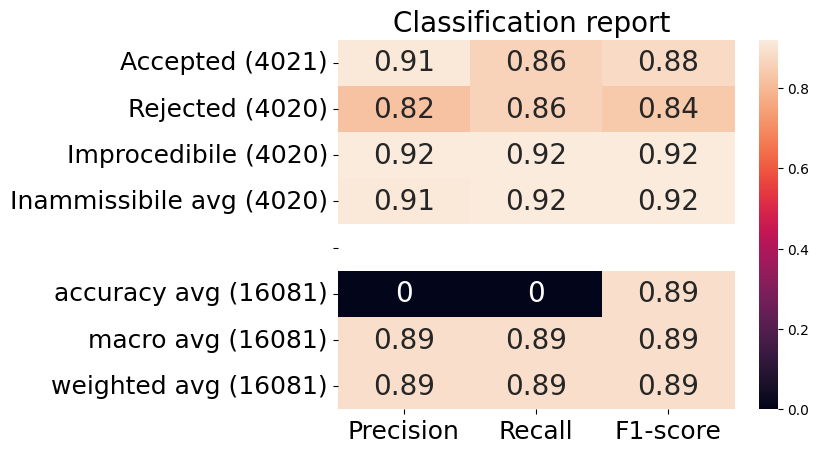

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# RandomForestClassifier
path_random_forest=path_model+"RandomForest/"
model=RandomForestClassifier()
if labels_agg!=True:
    f = path_random_forest+"RandomForestClassifier_moc_clf_Text"
else:
    f = path_random_forest+"RandomForestClassifier_moc_clf_Text_agg"
multi_classifier_randomclassifier,y_pred_randomclassifier=train_classifier(f,model,class_names_list)

### Prediction
---

START:  2023-07-27 11:42
Test Set Accuracy : 89.29428102512308 %


Classification Report : 

               precision    recall  f1-score   support

     Accepted       0.91      0.87      0.89      1980
     Rejected       0.83      0.86      0.85      1980
Improcedibile       0.92      0.92      0.92      1981
Inammissibile       0.91      0.92      0.92      1980

     accuracy                           0.89      7921
    macro avg       0.89      0.89      0.89      7921
 weighted avg       0.89      0.89      0.89      7921



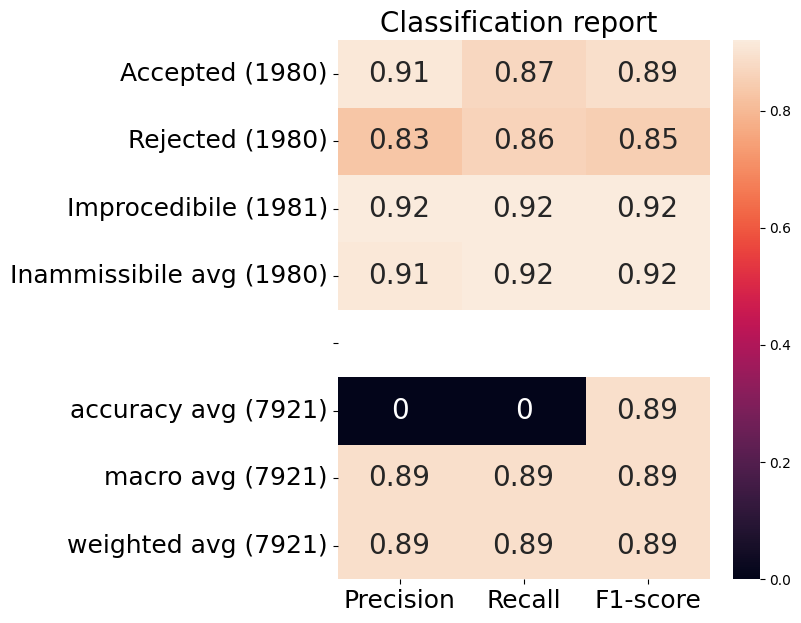

END:  2023-07-27 11:42
tempo impiegato 0d:00h:00m:03s


In [ ]:
start_time=time_calculate()
prediction(multi_classifier_randomclassifier,X_tfidf_test,y_test)
end_time=time_calculate(bool_t=False,start_time=start_time)

---
# Confronto su un nuovo dataset di Test per determinare il classificatore migliore

In [ ]:
ris_model=dict()

y_pred_SVC_test=multi_classifier_svm.predict(X_tfidf_test)
acc_prediction_SVC=accuracy_score(y_test,y_pred_SVC_test)
classification_report_prediction_SVC=classification_report(y_test,y_pred_SVC_test)
weighted_avg_SVC=float(classification_report_prediction_SVC.split('weighted avg')[1].split()[2])
print(("_"*55)+"\nSVC\naccuracy:",acc_prediction_SVC,"\nweighted avg:",weighted_avg_SVC)
print(classification_report_prediction_SVC)
ris_model['SVC']=weighted_avg_SVC

y_pred_RandomForest_test=multi_classifier_randomclassifier.predict(X_tfidf_test)
acc_prediction_RandomForest=accuracy_score(y_test,y_pred_RandomForest_test)
classification_report_prediction_RandomForest=classification_report(y_test,y_pred_RandomForest_test)
weighted_avg_RandomForest=float(classification_report_prediction_RandomForest.split('weighted avg')[1].split()[2])
print(("_"*55)+"\nRandomForest\naccuracy:",acc_prediction_RandomForest,"\nweighted avg:",weighted_avg_RandomForest)
print(classification_report_prediction_RandomForest)
ris_model['RandomForest']=weighted_avg_RandomForest

y_pred_DecisionTree_test=multi_classifier_decisiontree.predict(X_tfidf_test)
acc_prediction_DecisionTree=accuracy_score(y_test,y_pred_DecisionTree_test)
classification_report_prediction_DecisionTree=classification_report(y_test,y_pred_DecisionTree_test)
weighted_avg_DecisionTree=float(classification_report_prediction_DecisionTree.split('weighted avg')[1].split()[2])
print(("_"*55)+"\nDecisionTree\naccuracy:",acc_prediction_DecisionTree,"\nweighted avg:",weighted_avg_DecisionTree)
print(classification_report_prediction_DecisionTree)
ris_model['DecisionTree']=weighted_avg_DecisionTree

y_pred_AdaBoost_test=multi_classifier_adaboost.predict(X_tfidf_test)
acc_prediction_AdaBoost=accuracy_score(y_test,y_pred_AdaBoost_test)
classification_report_prediction_AdaBoost=classification_report(y_test,y_pred_AdaBoost_test)
weighted_avg_AdaBoost=float(classification_report_prediction_AdaBoost.split('weighted avg')[1].split()[2])
print(("_"*55)+"\nAdaBoost\naccuracy:",acc_prediction_AdaBoost,"\nweighted avg:",weighted_avg_AdaBoost)
print(classification_report_prediction_AdaBoost)
ris_model['AdaBoost']=weighted_avg_AdaBoost

max_acc_model=max(ris_model.values())
print("Il miglior modello è :",list(ris_model.keys())[list(ris_model.values()).index(max_acc_model)])

_______________________________________________________
SVC
accuracy: 0.7593738164373185 
weighted avg: 0.76
              precision    recall  f1-score   support

         0.0       0.70      0.70      0.70      1980
         1.0       0.72      0.68      0.70      1980
         2.0       0.87      0.84      0.86      1981
         3.0       0.75      0.82      0.78      1980

    accuracy                           0.76      7921
   macro avg       0.76      0.76      0.76      7921
weighted avg       0.76      0.76      0.76      7921

_______________________________________________________
RandomForest
accuracy: 0.8929428102512309 
weighted avg: 0.89
              precision    recall  f1-score   support

         0.0       0.91      0.87      0.89      1980
         1.0       0.83      0.86      0.85      1980
         2.0       0.92      0.92      0.92      1981
         3.0       0.91      0.92      0.92      1980

    accuracy                           0.89      7921
   macro avg

---
# PREDICTION TEST
---

In [ ]:
i=30
print(list(X_test)[i])

1.- ricorso previsto rito rsquo istante cittadino -omissis- impugnava provvedimento sfavorevole rubricato epigrafe particolare deduceva vizi violazione legge inerenti decreto legislativo 25 luglio 1998 n. 286 unitamente generiche violazioni disposizioni costituzionali comunitarie internazionali materia disciplina rsquo immigrazione nonch eacute svariati profili eccesso potere assumendo sostanza provvedimento finale atti istruttori connessi gravemente ingiusti lesivi propria posizione giuridica 2.- costituiva rsquo intimata amministrazione depositando relazione questura senza sollevare specifiche contestazioni 3.- fissata camera consiglio rsquo istanza cautelare veniva respinta evidenziandosi sommaria delibazione propria tale fase appariva sussistere fumus boni iuris atteso presenza decreto espulsione territorio nazionale accompagnamento coatto frontiera mezzo forza pubblica revoca permesso soggiorno costituisse atto dovuto 4.- indi scambiati ulteriori documenti parti depositata altra m

In [ ]:
t=pd.core.series.Series(list(X_test)[i])

In [ ]:
if os.path.isfile(path_model+"tfidf.pickle"):
  with open(path_model+"tfidf.pickle", "rb") as f:           # riapre il file in lettura ...
    tfizer_l=pickle.load(f)                         # ... carica il record ...
    f.close()
else:
  with open(path_model+"tfidf.pickle", "wb") as f:           # riapre il file in scrittura ...
    pickle.dump(tfizer, f)                         # ... salva il record ...
    tfizer_l=tfizer
    f.close()

In [ ]:
# Test value prediction
test_text = tfizer_l.transform(t)
val_test=y_test[0]
prediction = multi_classifier_randomclassifier.predict_proba(test_text)
print(t)
print(f"Real value: {class_names_list[int(val_test)]}")
print(f"Predicted value: \n\t-{class_names_list[int(0)]}-> {(prediction[0][0])} \n\t-{class_names_list[int(1)]}-> {(prediction[0][1])} \n\t-{class_names_list[int(2)]}-> {(prediction[0][2])} \n\t-{class_names_list[int(3)]}-> {(prediction[0][3])}")

0    1.- ricorso previsto rito rsquo istante cittad...
dtype: object
Real value: Accepted
Predicted value: 
	-Accepted-> 0.5315315315315315 
	-Rejected-> 0.12612612612612614 
	-Improcedibile-> 0.11711711711711713 
	-Inammissibile-> 0.22522522522522526


In [11]:
# We install the Simple Transformers library to use Transformer models in a simple way
import pandas as pd
import csv
import os
from pathlib import Path

import pickle
import sklearn
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import string

class_names_list={
            0: "Accepted",1:"Rejected",2:"Improcedibile",3:"Inammissibile",4:"Mixed",5:"NotComputed"
        }

print("RandomForestClassifier_moc_clf_Text_agg")
if os.path.isfile(path_model+"RandomForest/"+"RandomForestClassifier_moc_clf_Text_agg"):
  with open(path_model+"RandomForest/"+"RandomForestClassifier_moc_clf_Text_agg", "rb") as f:           # riapre il file in lettura ...
    clf = pickle.load(f)  # ... carica il record ...
    multi_classifier = clf
    print("MODELLO GIA' ADDESTRATO")
    f.close()
print("Inserisci il FactAndLaw da predirre:")
testo=input()

t=pd.core.series.Series(testo)
print(path_model+"tfidf.pickle")
if os.path.isfile(path_model+"tfidf.pickle"):
  with open(path_model+"tfidf.pickle", "rb") as f:           # riapre il file in lettura ...
    tfizer_l=pickle.load(f)                                  # ... carica il record ...
    f.close()

# Test value prediction
test_text = tfizer_l.transform(t)
prediction = multi_classifier.predict_proba(test_text)
print(t)
# val_test=0
# print(f"Real value: {class_names_list[int(val_test)]}")
print(f"Predicted value: \n\t-{class_names_list[int(0)]}-> {(prediction[0][0])} \n\t-{class_names_list[int(1)]}-> {(prediction[0][1])} \n\t-{class_names_list[int(2)]}-> {(prediction[0][2])} \n\t-{class_names_list[int(3)]}-> {(prediction[0][3])}")

RandomForestClassifier_moc_clf_Text_agg
MODELLO GIA' ADDESTRATO
Inserisci il FactAndLaw da predirre:
Il tizio deve essere arrestato perchè ha ucciso una persona
drive/MyDrive/Progetti-ING/model/tfidf.pickle
0    Il tizio deve essere arrestato perchè ha uccis...
dtype: object
Predicted value: 
	-Accepted-> 0.0 
	-Rejected-> 0.125 
	-Improcedibile-> 0.875 
	-Inammissibile-> 0.0
